In [1]:
from src.dataset import get_raw_training_data, get_raw_testing_data, get_labels
from src.spacy_helper import format_data_as_spacy, get_spacy_model, train, predict, predict_with_threshold

from src.metrics import score
from src.visualization import plot_confusion_matrix

import numpy as np
import time

In [2]:
raw_training_data = get_raw_training_data('./data/training_set.json')
raw_testing_data = get_raw_testing_data('./data/testing_set.json')

labels = get_labels(raw_training_data)

y_true = [r['intent'] for r in raw_testing_data]
y_true_t = [r['intent'] for r in raw_training_data]

X_train, y_train = format_data_as_spacy(raw_training_data)
X_test, y_test = format_data_as_spacy(raw_testing_data)


model = get_spacy_model(labels)

model = train(model, X_train, y_train, 10, test=(X_test, y_test))
model.to_disk(f"./model")

Training the model...
Iteration 0/10. train_loss: 17.005979012144962 test score:34.84516869891407%
Iteration 1/10. train_loss: 1.1148760513606248 test score:51.649300226471325%
Iteration 2/10. train_loss: 0.24382453184807673 test score:61.53432367930034%
Iteration 3/10. train_loss: 0.07820917619119427 test score:70.19014643553459%
Iteration 4/10. train_loss: 0.03136027507389372 test score:71.2093411443255%
Iteration 5/10. train_loss: 0.021577677651748672 test score:73.01428803163955%
Iteration 6/10. train_loss: 0.017540119857585523 test score:75.59479905195609%
Iteration 7/10. train_loss: 0.015791902291312 test score:72.05946501476768%
Iteration 8/10. train_loss: 0.012976967268784279 test score:74.19333977266722%
Iteration 9/10. train_loss: 0.01146545158540846 test score:74.73571498104852%


In [3]:
y_pred = predict(model, X_test)
y_pred_t = predict(model, X_train)

In [4]:
training_results = score(y_true_t, y_pred_t)
testing_results = score(y_true, y_pred)

In [5]:
print(testing_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.64      0.69      0.66        67
      find-flight       0.76      0.92      0.83        24
       find-hotel       0.61      0.78      0.68        55
  find-restaurant       0.94      0.70      0.80        93
       find-train       0.73      0.76      0.74        21
       irrelevant       0.88      0.91      0.89       677
provide-showtimes       0.59      0.71      0.65        14
         purchase       0.84      0.63      0.72       114

         accuracy                           0.83      1065
        macro avg       0.75      0.76      0.75      1065
     weighted avg       0.84      0.83      0.83      1065



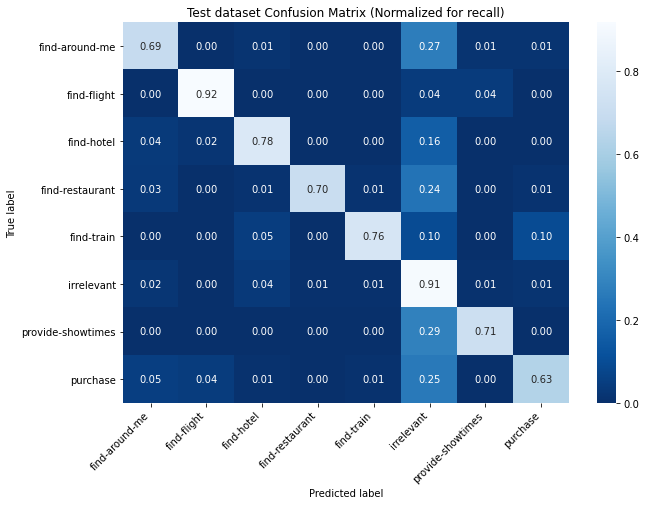

In [6]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

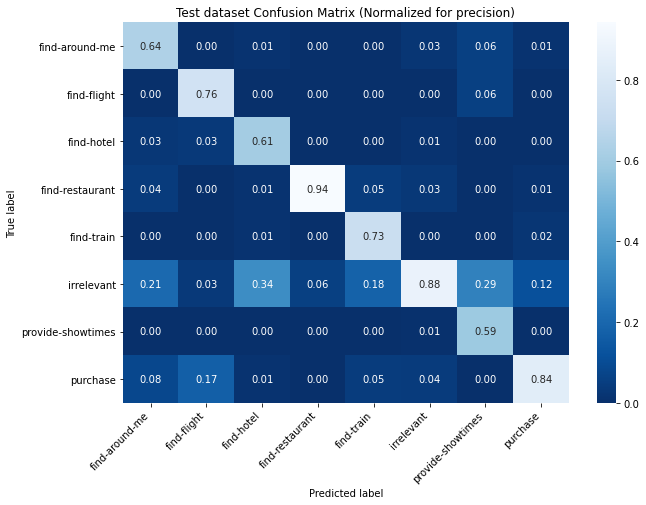

In [7]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[:, i] = cm_testing_metrics[:, i] / np.sum(cm_testing_metrics[:,i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for precision)", fmt=".2f")

On observe à travers ces matrices de confusion que notre modèle arrive à classer un plus grand nombre d'exemples respectivement à chacune des classes. Cependant, on remarque également qu'il a une précision qui est dans l'ensemble moins bonne que l'ancien modèle, et donc qu'il a plus tendance à attribuer des mauvais labels facilement. Ce point est rédhibitoire, surtout en prenant en compte que les "mauvais" labels ne sont majoritairement pas le label "irrelevant" comme attendu, contrairement à l'ancien modèle. Ainsi, dans le cas présent, l'ancien modèle répond mieux aux attentes que notre nouveau modèle. 
Pour y remédier, nous tentons alors de modifier notre prise de décision sur le retour du modèle en instaurant une fonction de seuil, qui introduit un pourcentage de certitude pour attribuer un label hors "irrelevant" au lieu de prendre la plus haute probabilité.

In [8]:
print(training_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.97      0.97      0.97       383
      find-flight       0.94      0.99      0.97       142
       find-hotel       0.98      0.98      0.98       316
  find-restaurant       1.00      0.97      0.99       469
       find-train       0.99      0.99      0.99       143
       irrelevant       0.99      0.99      0.99      3852
provide-showtimes       0.89      1.00      0.94       117
         purchase       1.00      0.98      0.99       613

         accuracy                           0.99      6035
        macro avg       0.97      0.99      0.98      6035
     weighted avg       0.99      0.99      0.99      6035



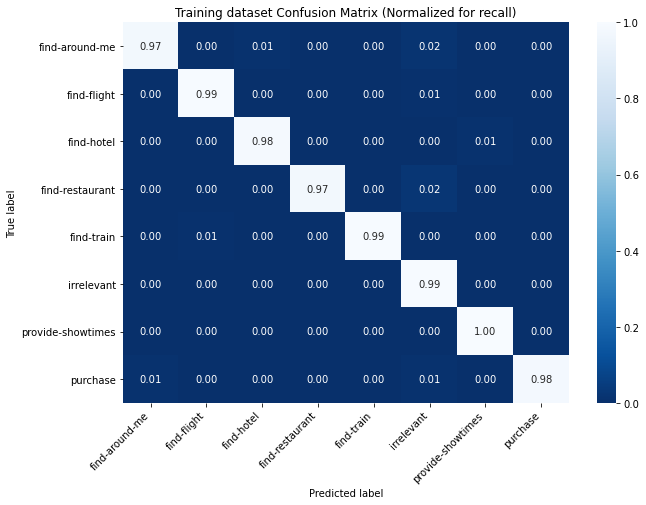

In [9]:
cm_testing_metrics = np.array(training_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Training dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

In [10]:
y_pred_thresh = predict_with_threshold(model, X_test, 0.5, "irrelevant")
y_pred_t_thresh = predict_with_threshold(model, X_train, 0.5, "irrelevant")

In [11]:
training_results_thresh = score(y_true_t, y_pred_t_thresh)
testing_results_thresh = score(y_true, y_pred_thresh)

In [12]:
print(testing_results_thresh['report'])

                   precision    recall  f1-score   support

   find-around-me       0.64      0.67      0.66        67
      find-flight       0.76      0.92      0.83        24
       find-hotel       0.67      0.76      0.71        55
  find-restaurant       0.94      0.68      0.79        93
       find-train       0.76      0.76      0.76        21
       irrelevant       0.87      0.92      0.89       677
provide-showtimes       0.59      0.71      0.65        14
         purchase       0.87      0.62      0.72       114

         accuracy                           0.84      1065
        macro avg       0.76      0.76      0.75      1065
     weighted avg       0.84      0.84      0.84      1065



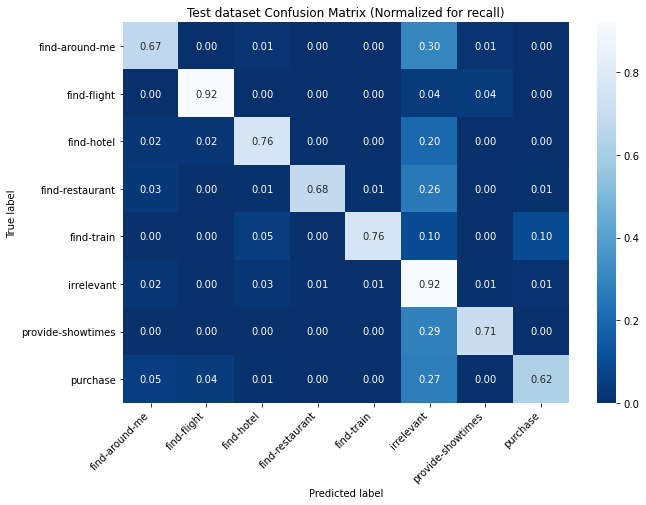

In [13]:
cm_testing_metrics = np.array(testing_results_thresh['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

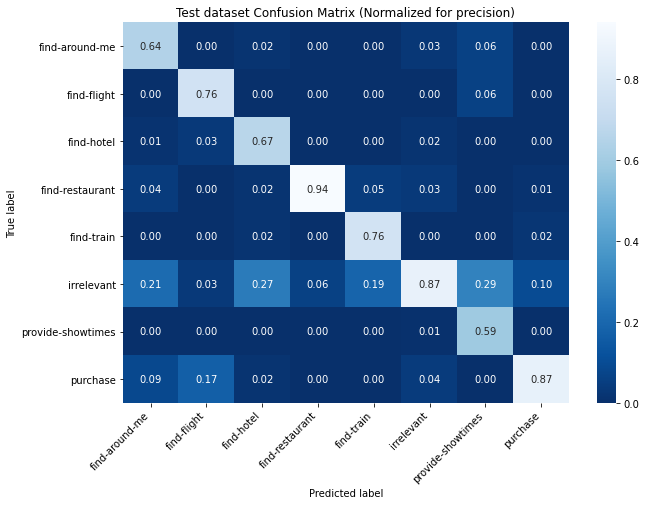

In [14]:
cm_testing_metrics = np.array(testing_results_thresh['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[:, i] = cm_testing_metrics[:, i] / np.sum(cm_testing_metrics[:,i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for precision)", fmt=".2f")

# With the Augmented Training set

In [26]:
raw_training_data = get_raw_training_data('./data/augmented_training_set.json')

for r in raw_training_data:
    if "message" in r:
        r["sentence"] = r["message"]

y_true_t = [r['intent'] for r in raw_training_data]

X_train, y_train = format_data_as_spacy(raw_training_data)

model = get_spacy_model(labels)

model = train(model, X_train, y_train, 18, test=(X_test, y_test))
model.to_disk(f"./model_augmented")

Training the model...
Iteration 0/18. train_loss: 20.58756566455122 test score:44.18682025909349%
Iteration 1/18. train_loss: 0.953205734025687 test score:64.51075386695163%
Iteration 2/18. train_loss: 0.18249770353759232 test score:68.99432100608793%
Iteration 3/18. train_loss: 0.05552501957208733 test score:72.81683127369863%
Iteration 4/18. train_loss: 0.03328413704184641 test score:74.76940018253987%
Iteration 5/18. train_loss: 0.02617205926708266 test score:75.11313167587664%
Iteration 6/18. train_loss: 0.021285510278175934 test score:74.57532595333191%
Iteration 7/18. train_loss: 0.01606597100703766 test score:76.84623029541557%
Iteration 8/18. train_loss: 0.014908567351767488 test score:76.82040749485182%
Iteration 9/18. train_loss: 0.013043093700446207 test score:76.55159652779466%
Iteration 10/18. train_loss: 0.010067116626292005 test score:75.24469085436827%
Iteration 11/18. train_loss: 0.008502545987589372 test score:74.98367236475316%
Iteration 12/18. train_loss: 0.00806946

In [10]:
y_pred = predict(model, X_test)
y_pred_t = predict(model, X_train)

In [11]:
training_results = score(y_true_t, y_pred_t)
testing_results = score(y_true, y_pred)

In [12]:
print(testing_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.61      0.64      0.63        67
      find-flight       0.91      0.83      0.87        24
       find-hotel       0.83      0.69      0.75        55
  find-restaurant       0.86      0.77      0.81        93
       find-train       0.68      0.71      0.70        21
       irrelevant       0.89      0.92      0.90       677
provide-showtimes       0.73      0.79      0.76        14
         purchase       0.78      0.75      0.76       114

         accuracy                           0.85      1065
        macro avg       0.79      0.76      0.77      1065
     weighted avg       0.85      0.85      0.85      1065



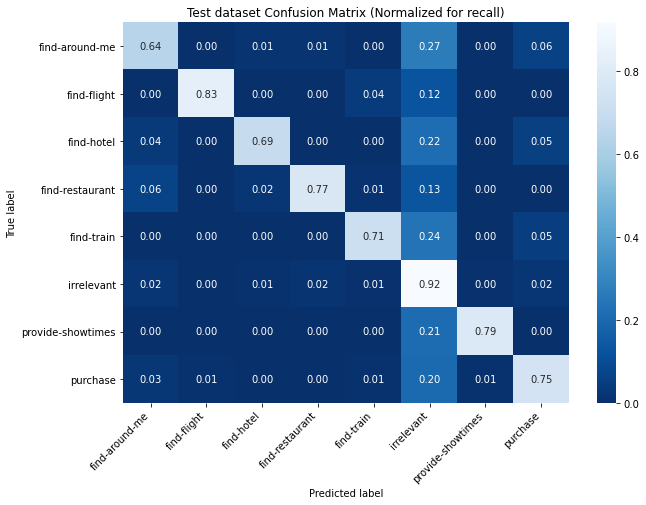

In [13]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

In [14]:
print(training_results['report'])

                   precision    recall  f1-score   support

   find-around-me       1.00      1.00      1.00       600
      find-flight       1.00      1.00      1.00       284
       find-hotel       1.00      1.00      1.00       500
  find-restaurant       1.00      1.00      1.00       700
       find-train       1.00      1.00      1.00       300
       irrelevant       1.00      1.00      1.00      3852
provide-showtimes       1.00      1.00      1.00       300
         purchase       1.00      1.00      1.00       800

         accuracy                           1.00      7336
        macro avg       1.00      1.00      1.00      7336
     weighted avg       1.00      1.00      1.00      7336

